In [50]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import librosa
import os
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from audio_process import *
from matplotlib import pyplot as plt
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import time
from torch.optim.lr_scheduler import OneCycleLR



samplerate = 16000
# data path
# SRP_audio_path = r'F:\audio\SRP_segmented\Voice'
# SRP_egg_path = r'F:\audio\SRP_segmented\EGG'
# VRP_audio_path = r'F:\audio\10s_segment\VRP_segmented\voice_test'
# VRP_egg_path = r'F:\audio\10s_segment\VRP_segmented\egg_test'
VRP_path = r'F:\audio\test_VRP_F02\test_Voice_EGG.wav'


In [51]:
if torch.cuda.is_available():
    print("CUDA is available. List of all available GPUs:")
    print(torch.cuda.device_count(), "GPUs available")
    for i in range(torch.cuda.device_count()):
        print("GPU", i, ":", torch.cuda.get_device_name(i))
else:
    print("CUDA is not available, using CPU instead.")

import sys
print("Python executable path:", sys.executable)



CUDA is available. List of all available GPUs:
1 GPUs available
GPU 0 : NVIDIA GeForce RTX 3070
Python executable path: g:\Conda\envs\EGG\python.exe


In [52]:
# define function and class
def segment_audio(audio, sr, frame_length_ms=12, hop_length_samples=1):

    # Calculate frame length in samples
    frame_length_samples = int(sr * frame_length_ms / 1000)

    # Number of frames
    num_frames = 1 + (len(audio) - frame_length_samples) // hop_length_samples

    # Initialize an array to hold the frames
    frames = np.zeros((num_frames, frame_length_samples))

    # Segment audio
    for i in range(num_frames):
        start_sample = i * hop_length_samples
        end_sample = start_sample + frame_length_samples
        frames[i] = audio[start_sample:end_sample]

    return frames

class AudioEGGDataset(Dataset):
    def __init__(self, audio_frames, egg_frames):
        """
        Initializes the dataset with pre-loaded data.
        :param audio_frames: A list or array of preprocessed and segmented audio frames.
        :param egg_frames: A list or array of preprocessed and segmented EGG frames.
        :param transform: Optional transform to be applied on a sample.
        """
        assert len(audio_frames) == len(egg_frames), "Audio and EGG frames must be the same length"
        self.audio_frames = audio_frames
        self.egg_frames = egg_frames

    def __len__(self):
        return len(self.audio_frames)

    def __getitem__(self, idx):
        audio_frame = self.audio_frames[idx]
        egg_frame = self.egg_frames[idx]

        # Convert arrays to PyTorch tensors
        audio_tensor = torch.from_numpy(audio_frame).float().unsqueeze(0)  # Add channel dimension if needed
        egg_tensor = torch.from_numpy(egg_frame).float().unsqueeze(0)      # Add channel dimension if needed

        return audio_tensor, egg_tensor

import torch
from torch import nn

class WaveNet(nn.Module):
    def __init__(self, input_channels, dilation_channels):
        super(WaveNet, self).__init__()
        self.dilation_channels = dilation_channels
        self.receptive_field_size = 1
        self.dilated_convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()  # Add batch normalization layers
        self.dropouts = nn.ModuleList()     # Add dropout layers

        dilations = [2**i for i in range(6)]
        self.dilated_convs.append(nn.Conv1d(input_channels, 2 * dilation_channels, kernel_size=3, padding=dilations[0]))
        self.batch_norms.append(nn.BatchNorm1d(2 * dilation_channels))  # Initialize batch norm for the first conv layer
        self.dropouts.append(nn.Dropout(p=0.1))  # Dropout layer with 10% probability

        for dilation in dilations[1:]:
            padding = dilation * (3 - 1) // 2
            self.dilated_convs.append(nn.Conv1d(dilation_channels, 2 * dilation_channels, kernel_size=3, padding=padding, dilation=dilation))
            self.receptive_field_size += dilation * 2
            self.batch_norms.append(nn.BatchNorm1d(2 * dilation_channels))
            self.dropouts.append(nn.Dropout(p=0.1))  # Consistent dropout probability across layers

        self.output_conv = nn.Conv1d(dilation_channels, 1, kernel_size=1)

    def forward(self, x):
        for conv, bn, do in zip(self.dilated_convs, self.batch_norms, self.dropouts):
            out = conv(x)
            out = bn(out)  # Apply batch normalization
            # Splitting the output of the convolution into filter and gate parts
            filter, gate = torch.split(out, self.dilation_channels, dim=1)  # Correct dimension for splitting is 1 (channels)
            x = torch.tanh(filter) * torch.sigmoid(gate)
            x = do(x)  # Apply dropout

        return self.output_conv(x)

    
class CosineSimilarityLoss(nn.Module):
    def __init__(self):
        super(CosineSimilarityLoss, self).__init__()

    def forward(self, outputs, targets):
        # Normalize outputs and targets to unit vectors
        outputs_norm = F.normalize(outputs, p=2, dim=1)
        targets_norm = F.normalize(targets, p=2, dim=1)
        # Compute cosine similarity
        cosine_loss = 1 - torch.sum(outputs_norm * targets_norm, dim=1).mean()
        return cosine_loss
    
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint_model.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path  # Save path for the best model

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score + self.delta:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.val_loss_min > val_loss:
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss


def create_experiment_folders(base_dir, experiment_name):
    """Create experiment directories for checkpoints, models, and logs."""
    chkpt_dir = os.path.join(base_dir, experiment_name, 'chkpt')
    models_dir = os.path.join(base_dir, experiment_name, 'models')
    logs_dir = os.path.join(base_dir, experiment_name, 'logs')
    
    os.makedirs(chkpt_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(logs_dir, exist_ok=True)
    
    return chkpt_dir, models_dir, logs_dir


In [53]:
# load data
wave, sr = librosa.load(VRP_path, sr=samplerate, mono=False) 
audio = wave[0]
egg = wave[1]
audio = voice_preprocess(audio, samplerate)
egg = process_EGG_signal(egg, samplerate)
audio = audio / np.max(np.abs(audio))
egg = egg / np.max(np.abs(egg))

# segment audio
audio_frames = segment_audio(audio, samplerate)
egg_frames = segment_audio(egg, samplerate)

print(audio_frames.shape)

# test audio
test_audio = np.array(audio[0:samplerate])
test_egg = np.array(egg[0:samplerate])


(3085808, 529)


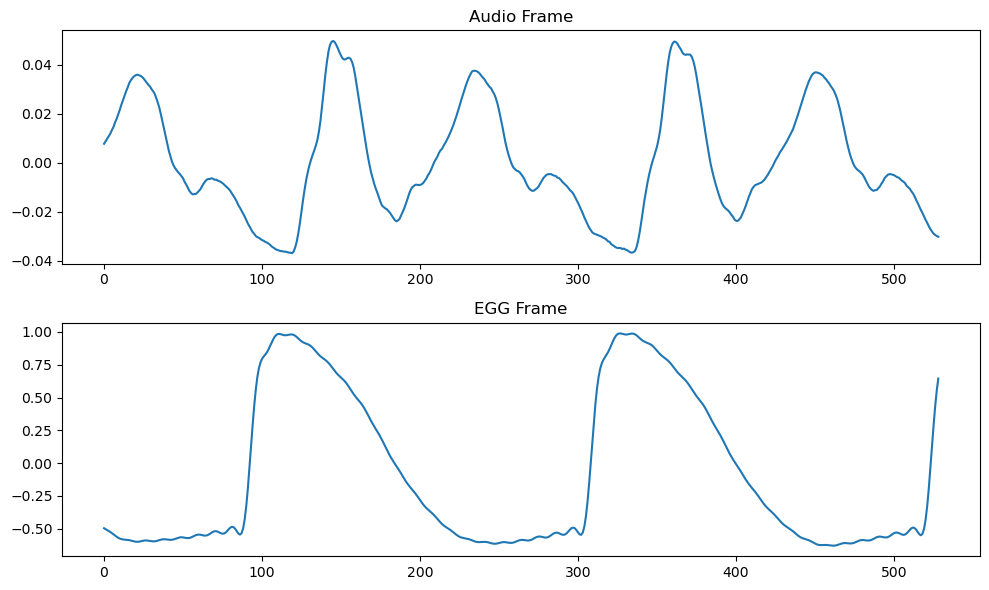

In [54]:
# plot a random audio and EGG frames
raw_index = np.random.randint(0, len(audio_frames))
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_frames[raw_index])
plt.title("Audio Frame")
plt.subplot(2, 1, 2)
plt.plot(egg_frames[raw_index])
plt.title("EGG Frame")
plt.tight_layout()
plt.show()


In [6]:
# Instantiate dataset
dataset = AudioEGGDataset(audio_frames, egg_frames)
# Create train and validation and test sets
batch_size = 512  # Adjust as necessary
train_size = int(0.85 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([512, 1, 192]) torch.Size([512, 1, 192])


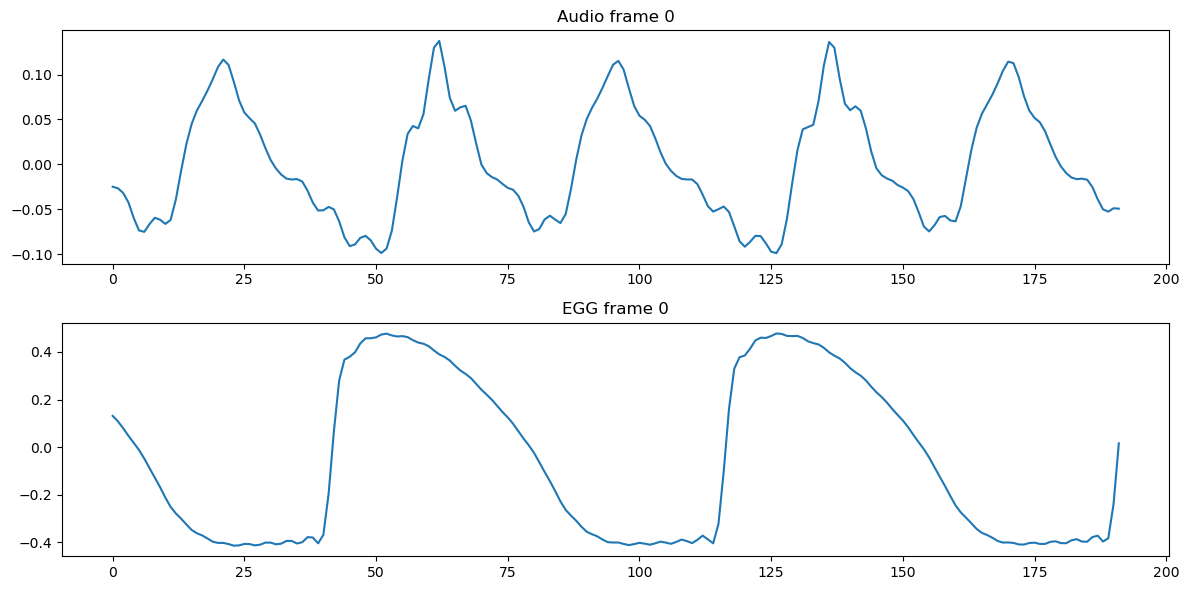

In [12]:
# plot dataset
audio, egg = next(iter(dataloader))
print(audio.shape, egg.shape)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(audio[240].squeeze())
plt.title('Audio frame 0')
plt.subplot(2, 1, 2)
plt.plot(egg[240].squeeze())
plt.title('EGG frame 0')
plt.tight_layout()
plt.show()


In [8]:
# Training
experiment_name = input("Enter the experiment name or identifier: ")
base_dir = r'F:\A2E git\A2E'
chkpt_dir, models_dir, logs_dir = create_experiment_folders(base_dir, experiment_name)


# Instantiate the model
channels = 32  # You may need to tune this based on your dataset
model = WaveNet(input_channels=1, dilation_channels=channels)

# Instantiate the TensorBoard writer
writer = SummaryWriter(log_dir=logs_dir)

# cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Instantiate the Cosine Similarity Loss
# criterion = CosineSimilarityLoss()
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

best_model_path = os.path.join(models_dir, 'best_model.pt')
early_stopping = EarlyStopping(patience=30, verbose=True, path=best_model_path)

for epoch in range(100):  # Adjust the number of epochs based on your needs
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        audio, egg = data
        audio = audio.to(device)
        egg = egg.to(device)

        optimizer.zero_grad()
        output = model(audio)
        loss = criterion(output, egg)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 10 == 0:  # Log every 10 batches
            writer.add_scalar('Training Loss', loss.item(), epoch * len(dataloader) + i)

    average_loss = running_loss / len(dataloader)
    writer.add_scalar('Average Training Loss', average_loss, epoch)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for data in val_dataloader:
            audio, egg = data
            audio = audio.to(device)
            egg = egg.to(device)
            output = model(audio)
            loss = criterion(output, egg)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_dataloader)
    writer.add_scalar('Validation Loss', val_loss, epoch)

    # Early stopping and saving best model based on validation loss
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning Rate', current_lr, epoch)

    # Save checkpoint
    if epoch % 10 == 0:  # Save every 10 epochs in chkpt folder
        checkpoint_path = os.path.join(chkpt_dir, f'checkpoint_{epoch}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss / len(dataloader),
            'val_loss': val_loss,
            'lr': current_lr
        }, checkpoint_path)

    for name, param in model.named_parameters():
        writer.add_histogram(f'{name}', param, epoch)
        if param.grad is not None:
            writer.add_histogram(f'{name}.grad', param.grad, epoch)


Validation loss decreased (inf --> 0.006401). Saving model...
Validation loss decreased (0.006401 --> 0.004116). Saving model...
Validation loss decreased (0.004116 --> 0.003166). Saving model...
Validation loss decreased (0.003166 --> 0.002636). Saving model...
Validation loss decreased (0.002636 --> 0.002244). Saving model...
Validation loss decreased (0.002244 --> 0.001974). Saving model...
Validation loss decreased (0.001974 --> 0.001726). Saving model...
Validation loss decreased (0.001726 --> 0.001644). Saving model...
Validation loss decreased (0.001644 --> 0.001483). Saving model...
Validation loss decreased (0.001483 --> 0.001408). Saving model...
Validation loss decreased (0.001408 --> 0.001384). Saving model...
Validation loss decreased (0.001384 --> 0.001381). Saving model...
Validation loss decreased (0.001381 --> 0.001365). Saving model...
Validation loss decreased (0.001365 --> 0.001362). Saving model...
Validation loss decreased (0.001362 --> 0.001352). Saving model...


In [32]:
# prediction
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for data in test_dataloader:
        audio, egg = data
        audio = audio.to(device)
        egg = egg.to(device)
        output = model(audio)

In [ ]:
# save the model
torch.save(model.state_dict(), 'WaveNet.pth')


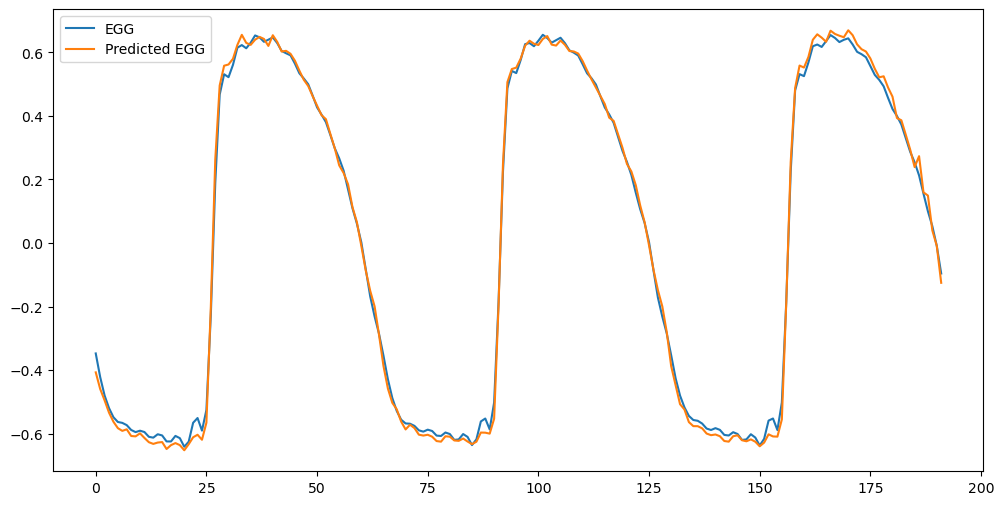

In [41]:
# plot prediction
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
egg = egg.cpu()
output = output.cpu()

# pick a random sample
sample = np.random.randint(0, len(egg))
egg_sample = egg[sample].squeeze()
output_sample = output[sample].squeeze()

# Plot the first sample
plt.figure(figsize=(12, 6))
plt.plot(egg_sample, label='EGG')
plt.plot(output_sample, label='Predicted EGG')
plt.legend()

plt.show()

In [ ]:
# save wav
import soundfile as sf
# save the first predicted EGG as wav
output_wav = output[0]
# save wav in the current folder using soundfile

sf.write('output.wav', output_wav.squeeze().numpy(), samplerate)

# save the first ground truth EGG as wav
egg_wav = egg[0]
sf.write('egg.wav', egg_wav.squeeze().numpy(), samplerate)


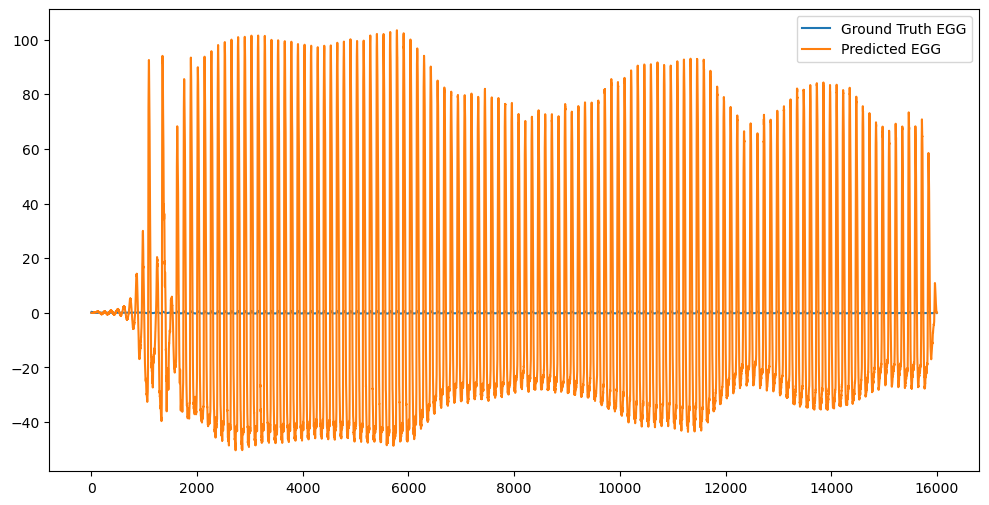

In [28]:


def predict_frames(frames, model, device):
    predicted_frames = np.zeros_like(frames)
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # No gradients needed
        for i in range(frames.shape[0]):
            frame = torch.from_numpy(frames[i, :]).float().unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            frame = frame.to(device)  # Move to device
            output = model(frame)
            predicted_frames[i, :] = output.squeeze().cpu().numpy()  # Remove batch dimension and move to cpu
    return predicted_frames

def overlap_and_add(frames, hop_length):
    output_length = hop_length * (frames.shape[0] - 1) + frames.shape[1]
    output = np.zeros(output_length)
    for i in range(frames.shape[0]):
        start = i * hop_length
        end = start + frames.shape[1]
        output[start:end] += frames[i, :]
    return output

# test audio
test_audio = np.array(audio[0:samplerate])
test_egg = np.array(egg[0:samplerate])

frame_length = 12
hop_length = 1
audio_frames = segment_audio(test_audio, samplerate, frame_length_ms= frame_length, hop_length_samples = hop_length)
predicted_egg_frames = predict_frames(audio_frames, model, device)
predicted_egg = overlap_and_add(predicted_egg_frames, hop_length)

# plot the predicted EGG
plt.figure(figsize=(12, 6))
plt.plot(test_egg, label='Ground Truth EGG')
plt.plot(predicted_egg[:len(test_egg)], label='Predicted EGG')
plt.legend()
plt.show()

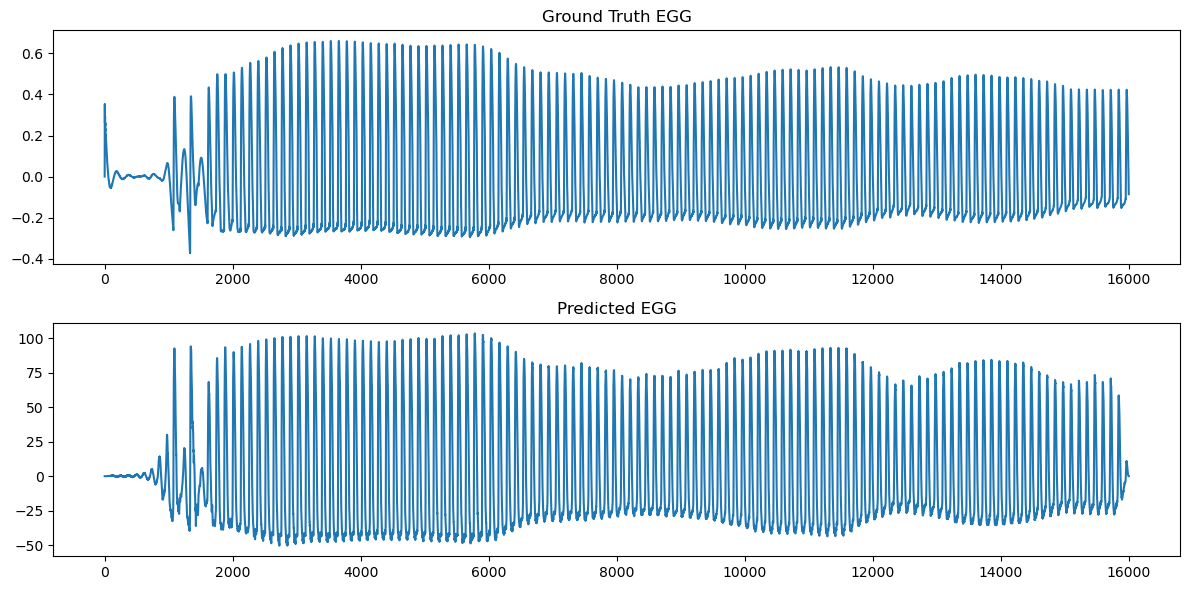

In [29]:
# plot the predicted EGG and target EGG in subplots
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(test_egg, label='Ground Truth EGG')
plt.title('Ground Truth EGG')
plt.subplot(2, 1, 2)
plt.plot(predicted_egg[:len(test_egg)], label='Predicted EGG')
plt.title('Predicted EGG')
plt.tight_layout()
plt.show()


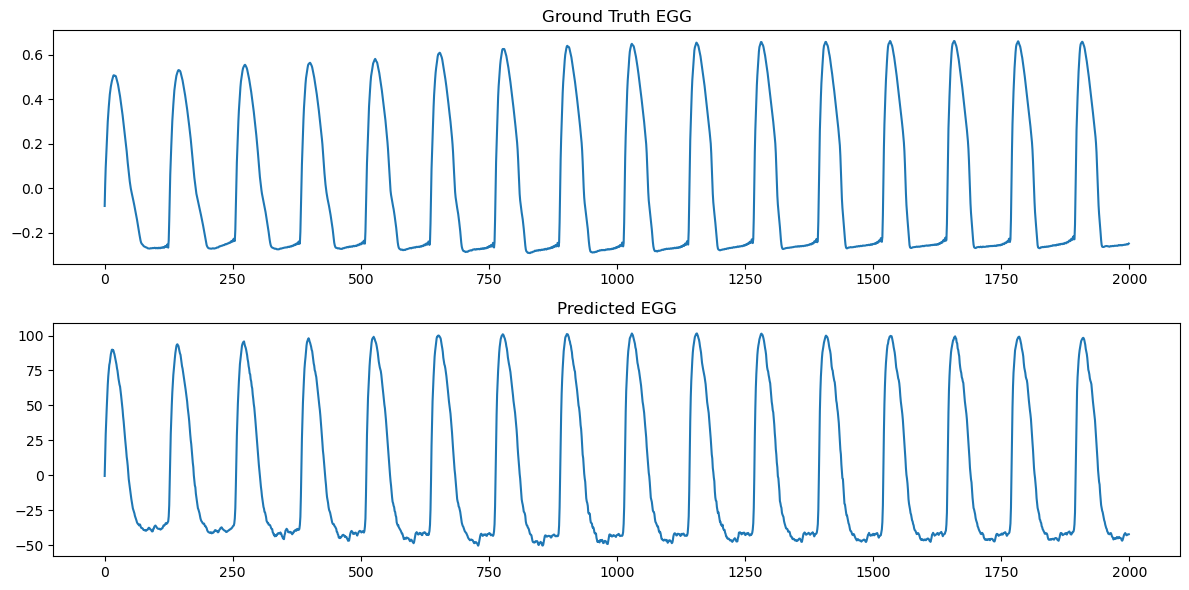

In [30]:
# plot the predicted EGG and target EGG in subplots
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(test_egg[2000:4000], label='Ground Truth EGG')
plt.title('Ground Truth EGG')
plt.subplot(2, 1, 2)
plt.plot(predicted_egg[2000:4000], label='Predicted EGG')
plt.title('Predicted EGG')
plt.tight_layout()
plt.show()
